In [1]:
import os
import sys
from collections import defaultdict
from pydantic import BaseSettings
from pathlib import Path
from typing import Any, Dict, List, Union

import os
import glob
import fiona
import pyproj
import rasterio as rio
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from rasterio.mask import mask as rmask
from rasterio.plot import show as rshow
from shapely import geometry as geom, ops

In [2]:
# setup a few variables and stuff from environment
class NbSettings(BaseSettings):
    class Config:
        env_file = ".env"
        env_file_encoding = "utf-8"
    vector_folder: Path
    delivery_id: str
    masks_folder: Path
    raster_folder: Path
    processed_folder: Path
    class2index: dict = {
        "background": 0,
        "Mono cristallino": 1,
        "Poli cristallino": 2
    }
    index2color: dict = {
        0: (0, 0, 0),
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255),
        255: (0, 0, 0)
    }
    index2class: dict = {v: k for k, v in class2index.items()}
    color2index: dict = {v: k for k, v in index2color.items()}
    chip_size: int = 256


In [3]:
settings = NbSettings()
for k, v in settings.dict().items():
    print(f"{k:<20s}: {v}")

vector_folder       : /mnt/data1/datasets/satellite/ithaca/panels
delivery_id         : 23042021
masks_folder        : /mnt/data1/datasets/satellite/ithaca/masks
raster_folder       : /mnt/data1/datasets/satellite/ithaca/ortho/2018
processed_folder    : /mnt/userdata/arnaudo_data/solar-panels/tiles-256
class2index         : {'background': 0, 'Mono cristallino': 1, 'Poli cristallino': 2}
index2color         : {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255), 255: (0, 0, 0)}
index2class         : {0: 'background', 1: 'Mono cristallino', 2: 'Poli cristallino'}
color2index         : {(0, 0, 0): 255, (255, 0, 0): 1, (0, 255, 0): 2, (0, 0, 255): 3}
chip_size           : 256


In [4]:
# retrieve a single shapefile corresponding to a delivery
shapefile_path = glob.glob(str((settings.vector_folder / settings.delivery_id).joinpath("*.shp")))
assert len(shapefile_path) == 1, "There should be only one shapefile per delivery!"
shapefile_path = shapefile_path[0]
shapefile_path

'/mnt/data1/datasets/satellite/ithaca/panels/23042021/pannelli_fot_23042021.shp'

In [5]:
# read data from the shapefile to create a dataframe, containing the geometry information of each panel
dataframe = gpd.read_file(shapefile_path)
dataframe

,objectid,id,regione,provincia,tipologia,categoria,orientamen,potenza,superficie,note,st_area_sh,st_length_,geometry
0,10804,1768,Piemonte,Alessandria,Industriale,Poli cristallino,Sud,199.94,306.595922,None,3.485145e-08,0.001625,"POLYGON ((8.66486 44.72285, 8.66487 44.72281, ..."
1,10805,1768,Piemonte,Alessandria,Industriale,Poli cristallino,Sud,199.94,344.450017,None,3.915431e-08,0.001689,"POLYGON ((8.66488 44.72271, 8.66489 44.72266, ..."
2,14186,823,Piemonte,Asti,Industriale,Poli cristallino,Sud,103.20,10.770322,None,1.227945e-09,0.000199,"POLYGON ((8.17426 44.90234, 8.17429 44.90230, ..."
3,14181,823,Piemonte,Asti,Industriale,Poli cristallino,Sud,103.20,8.821842,None,1.005793e-09,0.000139,"POLYGON ((8.17440 44.90215, 8.17438 44.90215, ..."
4,14184,823,Piemonte,Asti,Industriale,Poli cristallino,Sud,103.20,8.821813,None,1.005793e-09,0.000139,"POLYGON ((8.17425 44.90235, 8.17423 44.90234, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,5672,182,Piemonte,Alessandria,Industriale,Poli cristallino,Ovest,614.15,603.201477,None,6.878511e-08,0.001328,"POLYGON ((8.87986 44.90758, 8.87998 44.90759, ..."
2284,7437,1238,Piemonte,Alessandria,Industriale,Poli cristallino,Est,646.80,12.144082,None,1.384313e-09,0.000317,"POLYGON ((8.70254 44.88624, 8.70255 44.88624, ..."
2285,4239,167,Piemonte,Alessandria,Industriale,Poli cristallino,Est,198.00,598.102956,None,6.822054e-08,0.002482,"POLYGON ((8.52546 44.92299, 8.52541 44.92299, ..."
2286,10740,1434,Piemonte,Asti,Industriale,Poli cristallino,Sud,197.37,73.849127,None,8.419011e-09,0.000651,"POLYGON ((8.01544 44.90025, 8.01544 44.90022, ..."


In [6]:
dataframe.iloc[0].geometry

# Mask generation for raster tiles

In [7]:
def mask_to_rgb(mask: np.ndarray, palette:dict) -> np.ndarray:
    """Given an input batch, or single picture with dimensions [B, H, W] or [H, W], the utility generates
    an equivalent [B, H, W, 3] or [H, W, 3] array corresponding to an RGB version.
    The conversion uses the given palette, which should be provided as simple dictionary of indices and tuples, lists
    or arrays indicating a single RGB color. (e.g. {0: (255, 255, 255)})

    :param mask: input mask of indices. Each index should be present in the palette
    :type mask: np.ndarray
    :param palette: dictionary of pairs <index - color>, where colors can be provided in RGB tuple format
    :type palette: Dict[int, Iterable]
    :return: tensor containing the RGB version of the input index tensor
    :rtype: np.ndarray
    """
    lut = np.zeros((256, 3), dtype=np.uint8)
    for index, color in palette.items():
        lut[index] = np.array(color, dtype=np.uint8)
    return lut[mask]

In [8]:
def get_intersections(raster: rio.DatasetReader, panels: gpd.GeoDataFrame) -> Dict[str, list]:
    """Returns a dictionary of intersecting panels, grouped by panel category.add()

    Args:
        raster (rio.DatasetReader): raster image as dataset format
        panels (gpd.GeoDataFrame): panel dataframe containing a geometry field

    Returns:
        Dict[str, list]: dictionary of <category: list(polygons)>
    """
    polygons = defaultdict(list)
    bounds = geom.box(*raster.bounds)
    # iterate polygons and store the ones intersecting
    for _, row in panels.iterrows():
        if bounds.intersects(row.geometry):
            intersection = bounds.intersection(row.geometry)
            if isinstance(intersection, geom.MultiPolygon):
                intersection = list(intersection)
                polygons[row.id].extend(intersection)
            else:
                polygons[row.id].append(intersection)
    return polygons


In [9]:
def crop_raster(raster: rio.DatasetReader, polygons: List[geom.Polygon], padding: int = 64, min_size: int = 480) -> Any:
    out_mask, out_trs = rmask(src, polygons, crop=True, pad=True, pad_width=padding)
    if not all([dim >= min_size for dim in out_mask.shape[1:]]):
        centroid = geom.MultiPolygon(polygons).centroid
        pixel_x, pixel_y = raster.index(centroid.y, centroid.x)
        window = rio.windows.Window(pixel_x - min_size//2, pixel_y - min_size//2, min_size, min_size)
    return out_mask, out_trs

In [10]:
# gather the 105 images from Alessandria and Asti
raster_tiles = list(glob.glob(str(settings.raster_folder / "*.tif")))
assert len(raster_tiles) == 105

# get the CRS from the first image
with rio.open(raster_tiles[0], driver="GTiff") as src:
    raster_crs = src.crs
str(raster_crs)

'EPSG:32632'

In [11]:
# reproject panels to be in the same reference system
dataframe = dataframe.to_crs(str(raster_crs))
str(dataframe.crs)

'EPSG:32632'

# Tiling tests
Given that grid splits don't work out quite well, the current procedure to extrapolate panels is the following:
 - group panels by plant ID
 - for each raster image:
   - for each plant and list of polygons:
     - check if the group overlap with the current image
     - crop the group with a minimum size for height and width
     - divide in fixed tiles if one dimension is bigger than the fixed tile size

In [12]:
def project(shape: geom.Polygon, from_crs: pyproj.CRS, to_crs: pyproj.CRS = pyproj.CRS(3857)) -> geom.Polygon:
    projection = pyproj.Transformer.from_crs(from_crs, to_crs, always_xy=True).transform
    return ops.transform(projection, shape)
    

In [13]:
def box_dimentions(shape: geom.Polygon, crs: pyproj.CRS, resolution: float = 1.0):
    if crs != pyproj.CRS(3857):
        mercator_shape = project(shape, from_crs=crs)
    else:
        mercator_shape = shape
    minx, miny, maxx, maxy = mercator_shape.bounds
    resx, resy = resolution if isinstance(resolution, tuple) else (resolution, resolution)
    return np.ceil(np.abs(maxx - minx) / resx), np.ceil(np.abs(maxy - miny) / resy)


In [14]:
def crop(raster: rio.DatasetReader, polygons: List[geom.Polygon], min_size: int = 256, padding: Union[tuple, int] = 16) -> Any:
    padx, pady = padding if isinstance(padding, tuple) else (padding, padding)
    window = rio.features.geometry_window(raster, polygons, pad_x=padx, pad_y=pady)
    
    h = max(window.height, min_size)
    w = max(window.width, min_size)
    if h > window.height or w > window.width:
        centroid = geom.MultiPolygon(polygons).centroid
        px, py = src.index(centroid.x, centroid.y)
        window = rio.windows.Window(py - np.ceil(h/2), px - np.ceil(w/2), h, w)
    return window
    

In [15]:
def store_window(source: rio.DatasetReader, destination: Any, window: rio.windows.Window) -> None:
    metadata = source.meta.copy()
    metadata.update({
        "height": window.height,
        "width": window.width,
        "transform": rio.windows.transform(window, source.transform)
    })
    with destination.open(**metadata) as dataset:
        dataset.write(source.read(window=window))


In [16]:
def tile_overlapped(image: np.ndarray, tile_size: Union[tuple, int] = 256, channels_first: bool = False) -> np.ndarray:
    if len(image.shape) == 2:
        axis = 0 if channels_first else -1
        image = np.expand_dims(image, axis=axis)
    if channels_first:
        image = np.moveaxis(image, 0, -1)
    # assume height, width, channels from now on
    height, width, channels = image.shape
    tile_h, tile_w = tile_size if isinstance(tile_size, tuple) else (tile_size, tile_size)
    if height <= tile_h and width <= tile_w:
        raise ValueError("Image is smaller than the required tile size")
    # number of expected tiles
    tile_count_h = int(np.ceil(width / tile_h))
    tile_count_w = int(np.ceil(height / tile_w))
    # compute total remainder for the expanded window
    remainder_h = (tile_count_h * tile_h) - height
    remainder_w = (tile_count_w * tile_w) - width
    # divide remainders among tiles as overlap (floor to keep overlap to the minimum)
    overlap_h = int(np.floor(remainder_h / float(tile_count_h - 1))) if tile_count_h > 1 else 0
    overlap_w = int(np.floor(remainder_w / float(tile_count_w - 1))) if tile_count_w > 1 else 0
    # create the empty tensor to contain tiles
    tiles = np.empty((tile_count_h, tile_count_w, tile_h, tile_w, channels), dtype=image.dtype)
    for row in range(tile_count_h):
        for col in range(tile_count_w):
            # get the starting indices, accounting from initial positions
            x = max(row * tile_h - overlap_h, 0)
            y = max(col * tile_w - overlap_w, 0)
            # if it exceeds horizontally or vertically in the last rows or cols, increase overlap to fit
            if (x + tile_h) >= height:
                x -= abs(x + tile_h - height)
            if (y + tile_w) >= width:
                y -= abs(y + tile_w - width)
            # assign tile to final tensor
            tiles[row, col] = image[x:x + tile_h, y:y + tile_w, :]
    return tiles

## Plot some examples
Iterate some images and attempt the tiling mechanism.

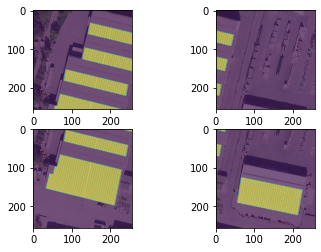

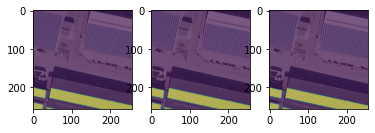

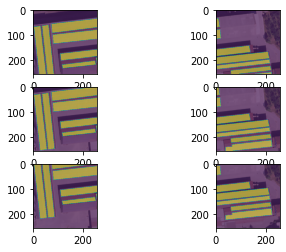

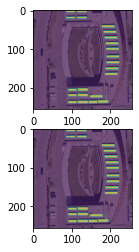

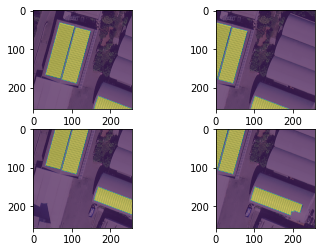

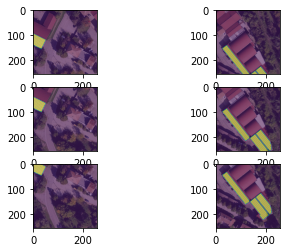

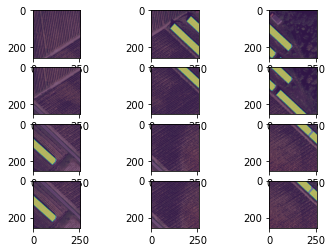

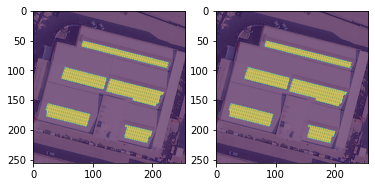

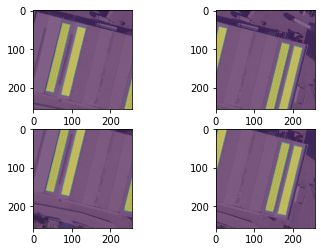

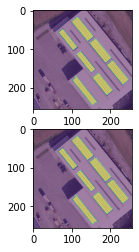

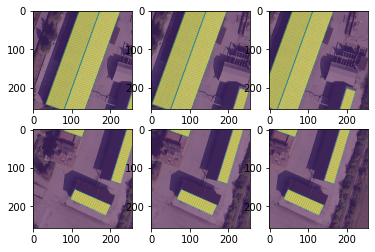

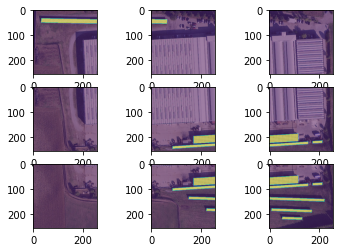

In [17]:
from matplotlib import pyplot as plt

for path in raster_tiles[:10]:
    with rio.open(path, driver="GTiff") as src:
        res = get_intersections(src, dataframe)
        for plant_id, polygons in res.items():
            window = crop(src, polygons, padding=32)
            with rio.io.MemoryFile() as tmp:
                store_window(src, tmp, window=window)
                with tmp.open(driver="GTiff") as window_src:
                    out_mask, out_transform = rio.mask.mask(window_src, polygons, crop=False, indexes=1)
                    out_mask = (out_mask > 0).astype(np.uint8) * 255
                    rgb = window_src.read()[:3].transpose(1, 2, 0)
                    
                    try:
                        rgb_tiles = tile_overlapped(rgb, channels_first=False)
                        msk_tiles = tile_overlapped(out_mask, channels_first=False)
                    except ValueError as e:
                        continue
                    rows, cols = rgb_tiles.shape[:2]
                    
                    fig, axes = plt.subplots(nrows=rows, ncols=cols)
                    axes = axes.reshape(rows, cols)
                    for r in range(rows):
                        for c in range(cols):
                            axes[r, c].imshow(rgb_tiles[r, c])
                            axes[r, c].imshow(msk_tiles[r, c], alpha=0.5, cmap="viridis")
                    plt.show()
                    plt.close(fig)

In [18]:
def store_raster(filename: Path, data: np.ndarray, count: int, channels_first: bool = False, **metadata) -> None:
    # rasterio wants channels first
    if not channels_first:
        data = np.moveaxis(data, -1, 0)
    # create the new file and save data
    with rio.open(filename, mode="w", driver="GTiff", count=count, **metadata) as dst:
        dst.write(data)

## Store tiles to file
Iterate on the whole set and save the generated tiles into a folder, defined in the settings.

In [125]:
import tifffile
from tqdm import tqdm


for path in tqdm(raster_tiles):
    with rio.open(path, driver="GTiff") as src:
        # first get intersections with the panels we have
        res = get_intersections(src, dataframe)
        # then, for each group, generate masks and store results to file
        for plant_id, polygons in res.items():
            window = crop(src, polygons, padding=32)
            # park the cropped window into an in-memory dataset
            with rio.io.MemoryFile() as tmp:
                store_window(src, tmp, window=window)
                with tmp.open(driver="GTiff") as window_src:
                    # generate the binary mask
                    out_mask, out_transform = rio.mask.mask(window_src, polygons, crop=False, indexes=1)
                    out_mask = (out_mask > 0).astype(np.uint8) * 255
                    rgbir = window_src.read()
                    # tile mask and image
                    try:
                        rgbir_tiles = tile_overlapped(rgbir, channels_first=True)
                        mask_tiles = tile_overlapped(out_mask, channels_first=True)
                    except ValueError as e:
                        continue
                    rows, cols = rgbir_tiles.shape[:2]
                    for r in range(rows):
                        for c in range(cols):
                            tile_id = f"{plant_id:06d}_{r:02d}_{c:02d}"
                            image_name = settings.processed_folder / f"{tile_id}_rgbir.tif"
                            mask_name = settings.processed_folder / f"{tile_id}_bin.tif"
                            tifffile.imsave(image_name, rgbir_tiles[r, c].transpose(2, 0, 1))
                            tifffile.imsave(mask_name, mask_tiles[r, c])


100%|██████████| 105/105 [00:22<00:00,  4.59it/s]
